# Exercises phase diagrams

First read some libraries needed. Notice, the functions we defined for plotting phase diagrams last time.


In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt 
import sympy as sp
from sympy import pprint
from IPython.display import display, Markdown, Latex
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#%matplotlib inline

The routines from the lectures.

In [60]:
def plot_flow(ax,rhs,xrange=[-2.5,2.5],yrange=[-2.5,2.5],xnum=100,ynum=100,nullclines=False,args=None):

    # Set up u,v space
    u = np.linspace(xrange[0], xrange[1], xnum)
    v = np.linspace(yrange[0], yrange[1], ynum)
    uu, vv = np.meshgrid(u, v)

# Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = rhs(0,np.array([uu[i,j], vv[i,j]]),args)


# Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel,color='grey')
#Nullclines
    if nullclines: 
        ax.contour(uu, vv, u_vel, [0],colors=('r'))
        ax.contour(uu, vv, v_vel, [0],colors=('b'))

    return ax

# A function that plots a path 
# def plot_solution(ax,rhs,y0,t_end,t_dim=2000,color='green',init_pt=True,linewidth=2.5):

#     t = np.linspace(0, t_end, t_dim)
#     X = sc.integrate.solve_ivp(rhs,t_span=[t[0],t[-1]],y0=y0,t_eval=t)
#     x,y=X.y
#     t=X.t
#     ax.plot(x,y, color=color,linewidth=linewidth)
#     if (init_pt):
#         ax=plot_point(ax,y0,color=color)
#     return ax

def get_solution(rhs, y0, t_end, t_dim=2000,args=None):
    t = np.linspace(0, t_end, t_dim)
    sol = sc.integrate.solve_ivp(rhs, t_span=[t[0], t[-1]], y0=y0, t_eval=t,args=args)
    return sol

def plot_solution(ax, rhs, y0, t_end, t_dim=2000, color='green', init_pt=True, linewidth=2.5, linestyle='-',args=None):
    sol = get_solution(rhs, y0, t_end, t_dim,args=args)
    x, y = sol.y
    ax.plot(x, y, color=color, linewidth=linewidth,linestyle=linestyle)
    if init_pt:
        ax = plot_point(ax, y0, color=color)
    return ax

def plot_point(ax, coord, color='black',markersize=20):
    """Add fixed points to plot."""
    x,y=coord
    ax.plot(x,y, '.', color='black', markerfacecolor=color, markersize=markersize)
    return ax


def jacobian(rhs, xy, eps=1e-8,args=None):
    """
    Compute the Jacobian matrix of a system of differential equations at a given point.
    Parameters:
    rhs (function): The right-hand side function of the differential equations. It should take two arguments: time (t) and state (xy).
    xy (array-like): The point (x, y) at which to evaluate the Jacobian.
    eps (float, optional): A small perturbation value for numerical differentiation. Default is 1e-8.
    Returns:
    numpy.ndarray: A 2x2 Jacobian matrix evaluated at the point (x, y).
    Note:
    This function uses finite differences to approximate the partial derivatives.

    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    
    f0 = np.array(rhs(0, xy,args))
    jac = np.zeros((2, 2))
    
    for i in range(2):
        dxy = np.zeros(2)
        dxy[i] = eps
        f1 = np.array(rhs(0, xy + dxy,args))
        jac[:, i] = (f1 - f0) / eps
    
    return jac

def eigenvalues_eigenvectors(jac):
    """
    Calculate the eigenvalues and eigenvectors of a given Jacobian matrix.
    Parameters:
    jac (numpy.ndarray): A square matrix representing the Jacobian matrix.
    Returns:
    tuple: A tuple containing two elements:
        - eigenvalues (numpy.ndarray): An array of eigenvalues.
        - eigenvectors (numpy.ndarray): An array of eigenvectors, where each column is an eigenvector corresponding to the eigenvalue at the same index.


    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    eigenvalues, eigenvectors = np.linalg.eig(jac)
    return eigenvalues, eigenvectors





def plot_jordan(ax,rhs,r0=[0,0],rr=1,num=25,vectors=True, color='blue',linewidth=1.5,linestyle='dashed',args=None):
    theta=np.linspace(0,2*np.pi, num)
    x=rr*np.cos(theta)+r0[0]
    y=rr*np.sin(theta)+r0[1]
    ax.plot(x,y,linewidth=linewidth, color=color)
    if vectors:
        U,V=rhs(0,[x,y],args)
        ax.quiver(x,y,U,V)

    return ax




def winding_number(rhs, r0, rr, num=1000,args=None):
    theta = np.linspace(0, 2 * np.pi, num)
    x = rr * np.cos(theta) + r0[0]
    y = rr * np.sin(theta) + r0[1]
    
    F,G=rhs(0,[x,y],args)
    angles = np.arctan2(G, F)
    integrated_angle = np.sum(np.diff(np.unwrap(angles)))
    
    return integrated_angle / (2 * np.pi)



In [57]:
def plot_vectors_along_line(ax, rhs, start_point, angle, length, num_vectors, color='black',args=None):
    """
    Plot vectors along a line in the phase plane.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axes on which to plot.
    rhs (function): The right-hand side function of the differential equations.
    start_point (list): The starting point [x, y] of the line.
    angle (float): The angle of the line with respect to the x-axis.
    length (float): The length of the line.
    num_vectors (int): The number of vectors to plot along the line.
    color (str): The color of the vectors.
    
    Returns:
    matplotlib.axes.Axes: The axes with the plotted vectors.
    """
    x0, y0 = start_point
    x = np.linspace(x0, x0 + length * np.cos(angle), num_vectors)
    y = np.linspace(y0, y0 + length * np.sin(angle), num_vectors)
    
    for i in range(num_vectors):
        dx, dy = rhs(0, [x[i], y[i]],args)
        ax.quiver(x[i], y[i], dx, dy, color=color)
    ax.plot(x, y, color=color, alpha=0.5)
    return ax


## Exercise 1
Consider the system
$$
\begin{array}{rl}
 \dot{x} = & - y + a x (x^2 + y^2),\\[0.5pt]
 \dot{y} = & x + a y (x^2+y^2),
\end{array}
$$
where $a$ is a parameter. Show that the linearised system incorrectly predicts that the origin is a center for all values of $a$, whereas in fact the origin is a stable spiral if $a<0$ and an unstable spiral if $a>0$. Create a phase diagram, using Python, and discuss the behaviour of the system as $a$ varies. 



In [3]:
x, y = sp.symbols('x y')
a=sp.symbols('a',real=True)
dx=-y+a*x*(x**2+y**2)
dy=x+a*y*(x**2+y**2)
r, theta = sp.symbols('r theta')
dx_polar = dx.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})
dy_polar = dy.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})

dr = sp.simplify(dx_polar * sp.cos(theta) + dy_polar * sp.sin(theta))
dtheta = sp.simplify((dy_polar * sp.cos(theta) - dx_polar * sp.sin(theta)) / r)

dr_latex = sp.latex(dr)
dtheta_latex = sp.latex(dtheta)

display(Markdown("The equations in polar coordinates are:"))
display(Markdown(f"$$\\dot{{r}} = {dr_latex}$$"))
display(Markdown(f"$$\\dot{{\\theta}} = {dtheta_latex}$$"))


The equations in polar coordinates are:

$$\dot{r} = a r^{3}$$

$$\dot{\theta} = 1$$



### Phase portrait

In [71]:

def rhs(t,xy,a=1):
    x,y=xy
    dx=- y + a * x*(x**2+y**2)
    dy=x + a * y*(x**2+y**2)
    return [dx,dy]

def plot_func(a=1):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')

    ax=plot_flow(ax,rhs,xrange=[-4,4],yrange=[-4,4],nullclines=True,args=a)
    ax=plot_jordan(ax,rhs,r0=[0,0],rr=2,num=25,vectors=True,args=(a,))
    plt.show()
    return ax



w = interactive(plot_func, a=(-1, 1, 0.1))
w.children[0].value = -1.
w





interactive(children=(FloatSlider(value=-1.0, description='a', max=1.0, min=-1.0), Output()), _dom_classes=('w…

## Exercise 2
$$
\begin{array}{rl}
 x'(t) = & - y +  x \sin(x^2 + y^2)\\[0.5pt]
 y'(t) = & x +  y\sin (x^2+y^2)
\end{array}
$$

In [72]:


dx=-y+a*x*sp.sin(x**2+y**2)
dy=x+a*y*sp.sin(x**2+y**2)
dx_polar = dx.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})
dy_polar = dy.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})

dr = sp.simplify(dx_polar * sp.cos(theta) + dy_polar * sp.sin(theta))
dtheta = sp.simplify((dy_polar * sp.cos(theta) - dx_polar * sp.sin(theta)) / r)

dr_latex = sp.latex(dr)
dtheta_latex = sp.latex(dtheta)

display(Markdown("The equations in polar coordinates are:"))
display(Markdown(f"$$\\dot{{r}} = {dr_latex}$$"))
display(Markdown(f"$$\\dot{{\\theta}} = {dtheta_latex}$$"))



The equations in polar coordinates are:

$$\dot{r} = 0.05 r \sin{\left(r^{2} \right)}$$

$$\dot{\theta} = 1$$



### Phase portrait

<Axes: xlabel='X', ylabel='Y'>

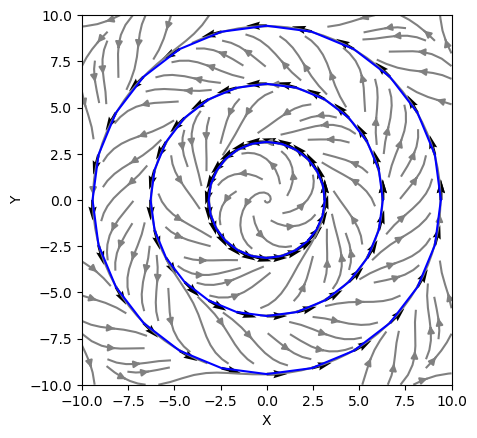

In [73]:
def rhs_2(t,xy,a=1):
    x,y=xy
    dx=- y +  x*np.sin(np.sqrt(x**2+y**2))
    dy=x +  y*np.sin(np.sqrt(x**2+y**2))
    return [dx,dy]


a=1  # the coordinates for the centre of the circle
rrange=10

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,rhs_2,xrange=[-rrange,rrange],yrange=[-rrange,rrange],nullclines=False)

plot_jordan(ax,rhs_2,r0=[0,0],rr=np.pi,num=25,vectors=True, color='blue',linewidth=1.5)
plot_jordan(ax,rhs_2,r0=[0,0],rr=2*np.pi,num=25,vectors=True, color='blue',linewidth=1.5)
plot_jordan(ax,rhs_2,r0=[0,0],rr=3*np.pi,num=25,vectors=True, color='blue',linewidth=1.5)



## Exercise 5
$$
\begin{array}{rl}
 \dot{r} = & r(1-r^2)+ \mu r \cos(\theta)\\[0.5pt]
 \dot{\theta} = & 1
\end{array}
$$

In [79]:
def rhs_5_polar(t,rtheta,mu=1):
    r,theta=rtheta
    dr= r*(1-r**2)+mu*r*np.cos(theta)
    dtheta= 1
    return [dr,dtheta]

mu=0.1

def rhs_5(t,xy,mu=0):
    x,y=xy
    r=np.sqrt(x**2+y**2)
    theta=np.arctan2(y,x)
    dr, dtheta=rhs_5_polar(t,[r,theta],mu)
    dx=dr*np.cos(theta)-r*np.sin(theta)*dtheta
    dy=dr*np.sin(theta)+r*np.cos(theta)*dtheta
    return [dx,dy]

  


def plot_func(mu=0):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    rrange=2
    
    ax=plot_flow(ax,rhs_5,xrange=[-rrange,rrange],yrange=[-rrange,rrange],nullclines=False,args=mu)
    plot_jordan(ax,rhs_5,r0=[0,0],rr=0.99*np.sqrt(1-mu),num=25,vectors=True, color='blue',linewidth=1.5,args=mu)
    plot_jordan(ax,rhs_5,r0=[0,0],rr=1.01*np.sqrt(1+mu),num=25,vectors=True, color='blue',linewidth=1.5,args=mu)
    plot_solution(ax,rhs_5,[0.01,0.1],t_end=10,color='green',init_pt=True,linewidth=2.5,args=[mu])
    plot_solution(ax,rhs_5,[1.5,1.5],t_end=10,color='green',init_pt=True,linewidth=2.5,args=[mu])

    plt.show()
    display(Latex(f"**Two solutions and two circles with center in origin and with radius $r_{{-}}\sim{0.99*np.sqrt(1-mu):.2f}$ and $r_{{+}}\sim{1.01*np.sqrt(1+mu):.2f}$:** "))

    return ax

w=interactive(plot_func,mu=(-1,1,0.1))
w.children[0].value=0
w

interactive(children=(FloatSlider(value=0.0, description='mu', max=1.0, min=-1.0), Output()), _dom_classes=('w…

## Exercise 6
$$
\begin{array}{rl}
 \dot{x} = & -a x + y\\[0.5pt]
 \dot{y} = & \frac{x^2}{1+x^2}- y
\end{array}
$$

In [99]:
from IPython.display import display, Latex

a=sp.symbols('a',real=True)
x,y = sp.symbols('x y')
dx_eq=-a*x+y
dy_eq=x**2/(1+x**2)-y
rhs_sp = [dx_eq, dy_eq]
equilibrium_points = sp.solve([dx_eq, dy_eq], (x, y))
equilibrium_points = [sp.simplify(point) for point in equilibrium_points]
#print("Equilibrium points:", equilibrium_points)

jac = sp.Matrix(rhs_sp).jacobian([x, y])



def evaluate_equilibrium_points(a_value):
    a_val = sp.N(a_value)
    eq_points = [point.subs(a, a_val) for point in equilibrium_points]
    eq_points = [(point[0].evalf(), point[1].evalf()) for point in eq_points]
    return eq_points

def find_eigenvalues_eigenvectors(a_value):
    a_val = sp.N(a_value)
    eq_points = [point.subs(a, a_val) for point in equilibrium_points]
    results = []
    for point in eq_points:
        jac_at_eq = jac.subs({x: point[0], y: point[1],a:a_val})
        eigenvalues = jac_at_eq.eigenvals()
        eigenvectors = jac_at_eq.eigenvects()
        results.append((point, eigenvalues, eigenvectors))
    return results


# Example usage
a_value = 0.2
eigen_results = find_eigenvalues_eigenvectors(a_value)
for point, eigenvalues, eigenvectors in eigen_results:
    display(Latex(f"**Equilibrium point for $a={a_value}$:** $\\mathbf{{({sp.latex(point[0])}, {sp.latex(point[1])})}}$"))
    stability = "stable" if all(ev.as_real_imag()[0] < 0 for ev in eigenvalues.keys()) else "unstable"
    if all(ev.is_real for ev in eigenvalues.keys()):
        display(Latex(f"Eigenvalues: {eigenvalues.keys()} (Real, {stability})"))
        display(Latex(f"Eigenvectors: {eigenvectors}"))
    else:
        display(Latex(f"Eigenvalues: {eigenvalues.keys()} (Complex, {stability})"))
   




<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [124]:
### Phase portrait
dx_func = sp.lambdify((x, y, a), dx, 'numpy')
dy_func = sp.lambdify((x, y, a), dy, 'numpy')

def rhs_6(t,xy,a=1):
    x,y=xy
    b=1
    #dx=dx_func(x,y,a)
    #dy=dy_func(x,y,a)
    
    dx= - a*x+y
    dy= x**2/(b+x**2)-y
    return [dx,dy]

def plot_func(a=1):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')
    eq_points = [point for point in evaluate_equilibrium_points(a) if all(coord.is_real for coord in point)]
    xrange = float(max(2.09, max([abs(point[0]) for point in eq_points]) + 0.5))
    yrange=float(max(1.5,max([abs(point[1]) for point in eq_points])+0.5))


    ax=plot_flow(ax,rhs_6,xrange=[0,xrange],yrange=[0.0,yrange],nullclines=True,args=a)
    
    eigen_results = find_eigenvalues_eigenvectors(a)
    for eigen_result in eigen_results:
        point, eigenvalues, eigenvectors = eigen_result
        if all(ev.is_real for ev in eigenvalues.keys()) and any(ev > 0 for ev in eigenvalues.keys()) and any(ev < 0 for ev in eigenvalues.keys()):
            for eigenvector in eigenvectors:
                eigenvector = np.array(eigenvector[2]).astype(np.float64).flatten()
                plot_solution(ax, rhs_6, [point[0] + 0.01 * eigenvector[0], point[1] + 0.01 * eigenvector[1]], t_end=-100, color='green', init_pt=False, linewidth=2.5, args=[a])
                plot_solution(ax, rhs_6, [point[0] - 0.01 * eigenvector[0], point[1] - 0.01 * eigenvector[1]], t_end=-100, color='green', init_pt=False, linewidth=2.5, args=[a])
            plot_point(ax, [point[0], point[1]], color='red', markersize=10)
            #plot_point(ax, [point[0], point[1]], color='red', markersize=10)
    ax.set_xlim(0, xrange)
    ax.set_ylim(0, yrange)
    plt.show()
    return ax

w=interactive(plot_func,a=(0,0.6,0.05))
w.children[0].value=0.6
w





interactive(children=(FloatSlider(value=0.6, description='a', max=0.6, step=0.05), Output()), _dom_classes=('w…

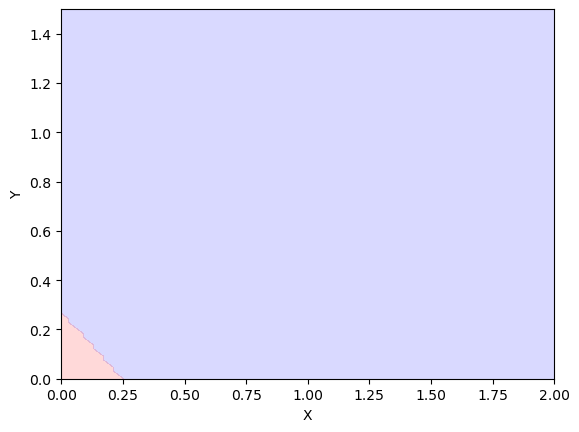

In [49]:

# Define a grid of initial conditions
x_vals = np.linspace(0, rrange, 100)
y_vals = np.linspace(0, 1.5, 100)
X, Y = np.meshgrid(x_vals, y_vals)
basin = np.zeros(X.shape)

# Define a function to determine the basin of attraction
def basin_of_attraction(x0, y0, t_end=100, a=0.2):
    sol = get_solution(rhs_6, [x0, y0], t_end, t_dim=2000, args=[a])
    x, y = sol.y
    if np.linalg.norm([x[-1], y[-1]]) < 0.01:
        return 1  # Attracted to the origin
    else:
        return 0  # Not attracted to the origin

# Compute the basin of attraction for each initial condition
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        basin[i, j] = basin_of_attraction(X[i, j], Y[i, j])

# Plot the basin of attraction
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
ax.contourf(X, Y, basin, levels=[-0.5, 0.5, 1.5], colors=['blue', 'red'], alpha=0.15)
plt.show()

## Exercise 7
$$
\begin{array}{rl}
 \dot{x} = & - x + a y + x^2 y\\[0.5pt]
 \dot{y} = & b −a y−x^2 y
\end{array}
$$

0.0574794331177344


TypeError: rhs_7() missing 1 required positional argument: 'b'

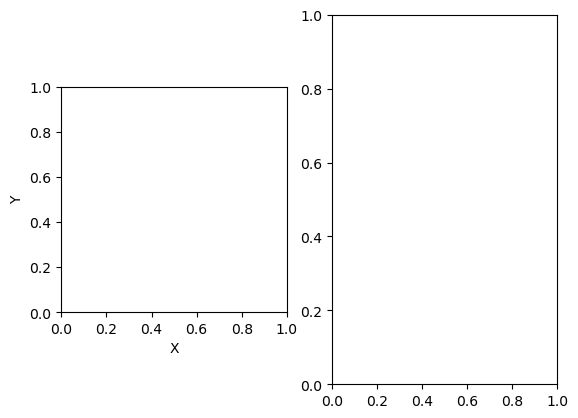

In [146]:

a=0.05
b=0.9

print(-b**2- 0.5+ 0.5*np.sqrt(8*b**2+1))
def rhs_7(t, xy, a,b):
    x,y=xy
    #a, b = args
    dx= - x + a * y + x**2 * y
    dy= b - a * y - x**2 * y
    return [dx,dy]

rrange=3

fig, axs = plt.subplots(1, 2)
ax=axs[0]
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
rrange=b/a+1.5
plot_flow(ax, rhs_7, xrange=[0, rrange], yrange=[0, rrange], nullclines=True, args=(a, b))
plot_vectors_along_line(ax, rhs_7, start_point=[0,0], angle=0, length=rrange, num_vectors=10, color='black',args=[a, b])
plot_vectors_along_line(ax, rhs_7, start_point=[0,b/a+0.01], angle=0, length=rrange, num_vectors=10, color='black',args=[a, b])
plot_vectors_along_line(ax, rhs_7, start_point=[0,0], angle=np.pi/2, length=b/a, num_vectors=10, color='black',args=[a, b])
#plot_solution(ax,rhs_7,[0,0],t_end=100,color='green',init_pt=True,linewidth=2.5,args=([a,b]))
#plot_solution(ax,rhs_7,[0,b/a],t_end=100,color='orange',init_pt=True,linewidth=2.5,args=[a,b])
#plot_solution(ax,rhs_7,[b+0.01,b/(b**2+a)],t_end=100,color='red',init_pt=True,linewidth=2.5,args=[a,b])

ax=axs[1]
ax.set_xlabel('X')
ax.set_ylabel('Y')
rrange=np.max([b,b/(a+b**2)])+2.5
ax.set_aspect('equal')
plot_flow(ax, rhs_7, xrange=[0, rrange], yrange=[0, rrange], nullclines=True, args=[a, b])
plot_solution(ax,rhs_7,[0,b/a],t_end=100,color='orange',init_pt=True,linewidth=4.5,args=tuple({a, b}))
#plot_solution(ax,rhs_7,[0,0],t_end=100,color='green',init_pt=True,linewidth=2.5,args=[a,b])
#plot_solution(ax,rhs_7,[b+0.01,b/(b**2+a)],t_end=200,color='red',init_pt=True,linewidth=1.5,args=[a,b])

ax.set_xlim([0, rrange])
ax.set_ylim([0, rrange])

In [17]:
import sympy as sp
from sympy import pprint

x,y=sp.symbols('x y',real=True)
a,b=sp.symbols('a b',real=True,positive=True)
dx=- x+a*y+x**2*y
dy= b - a*y- x**2*y

equilibrium_points = sp.solve([dx, dy], (x, y))
print("Equilibrium points:", equilibrium_points)



Equilibrium points: [(b, b/(a + b**2))]


In [18]:
jac=sp.Matrix([dx,dy]).jacobian([x,y])
print("Jacobian matrix:")
jac

Jacobian matrix:


Matrix([
[2*x*y - 1,  a + x**2],
[   -2*x*y, -a - x**2]])

In [19]:
# Substitute equilibrium points into the Jacobian matrix
equilibrium_point = equilibrium_points[0]
jac_at_eq = jac.subs({x: equilibrium_point[0], y: equilibrium_point[1]})

# Find the characteristic polynomial
char_poly = jac_at_eq.charpoly()

print("Characteristic polynomial:")
print(char_poly)   

Characteristic polynomial:
PurePoly(lambda**2 + (a**2 + 2*a*b**2 + a + b**4 - b**2)/(a + b**2)*lambda + a + b**2, lambda, domain='ZZ(a,b)')


## Exercise 8

Given the following system:
$$\begin{array}{ccc}
 \dot{x}&=& 4-2 y, \\ 
\dot{y}&=& 12-3x^2. 
\end{array}
$$

- Find the equilibrium points of the system and use linear analysis to classify the equilibrium points.  
- Show that the system is Hamiltonian and find the Hamiltonian function. 
- Plot a phase diagram in Python. Can you plot the homoclinic orbit that connects the saddle point to itself?



In [20]:
x,y=sp.symbols('x y',real=True)

dx= 4 - 2*y
dy= 12 - 3*x**2

equilibrium_points = sp.solve([dx, dy], (x, y))
equilibrium_points = [sp.simplify(point) for point in equilibrium_points]
print(equilibrium_points)

jac = sp.Matrix([dx, dy]).jacobian([x, y])
for eq_point in equilibrium_points:
    jac_at_eq = jac.subs({x: eq_point[0], y: eq_point[1]})
    eigenvalues = jac_at_eq.eigenvals()
    display(Markdown(f"**Equilibrium point:** $\\mathbf{{({sp.latex(eq_point[0])}, {sp.latex(eq_point[1])})}}$"))
    display(Markdown(f"Eigenvalues: {eigenvalues}"))

[(-2, 2), (2, 2)]


**Equilibrium point:** $\mathbf{(-2, 2)}$

Eigenvalues: {-2*sqrt(6)*I: 1, 2*sqrt(6)*I: 1}

**Equilibrium point:** $\mathbf{(2, 2)}$

Eigenvalues: {-2*sqrt(6): 1, 2*sqrt(6): 1}

In [21]:
from sympy import symbols, Function, Eq, integrate, dsolve, Symbol

# Define the symbols
x, y = symbols('x y')
H = Function('H')(x, y)
C = Function('C')(x)
C_1 = Symbol('C1')
# Define the system of equations
dx = 4 - 2*y
dy = 12 - 3*x**2

# Integrate to find H
H_y = integrate(dx, y)

# Define the differential equation
diff_eq = Eq((H_y + C).diff(x) + dy, 0)

# Solve the differential equation
solution = dsolve(diff_eq, C)
H=solution.rhs.subs(C_1,0) + H_y
H

x**3 - 12*x - y**2 + 4*y

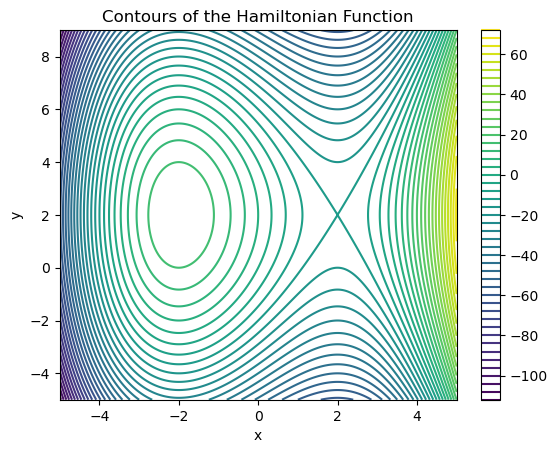

In [22]:
# Define the Hamiltonian function
H_func = sp.lambdify((x, y), H, 'numpy')

# Create a grid of x and y values
x_vals = np.linspace(-5, 5, 400)
y_vals = np.linspace(-5, 9, 400)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute the Hamiltonian values on the grid
H_vals = H_func(X, Y)

# Plot the contours of the Hamiltonian function
fig, ax = plt.subplots()
contour = ax.contour(X, Y, H_vals, levels=50, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Contours of the Hamiltonian Function')
plt.colorbar(contour)
plt.show()

In [23]:
H_func(2,2)

-12

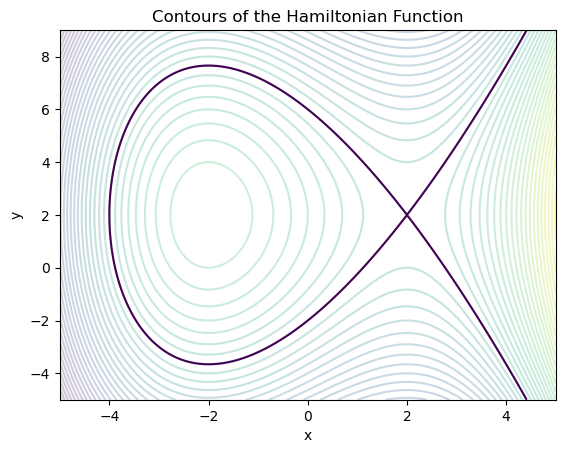

In [24]:
# Define the Hamiltonian function
H_func = sp.lambdify((x, y), H, 'numpy')

# Create a grid of x and y values
x_vals = np.linspace(-5, 5, 400)
y_vals = np.linspace(-5, 9, 400)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute the Hamiltonian values on the grid
H_vals = H_func(X, Y)

# Plot the contours of the Hamiltonian function
fig, ax = plt.subplots()
contour = ax.contour(X, Y, H_vals, levels=50, cmap='viridis', alpha=0.25)
contour = ax.contour(X, Y, H_vals, levels=[-12], cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Contours of the Hamiltonian Function')
#plt.colorbar(contour)
plt.show()

## Exercise 9
$$\begin{array}{ccc}
\dot{x}&=& -x - x y^2, \\ 
\dot{y}&=& -y - x^2 y 
\end{array}
$$



In [291]:
x,y=sp.symbols('x y',real=True)

dx= -x - x*y**2
dy= - y - x**2*y

equilibrium_points = sp.solve([dx, dy], (x, y))
equilibrium_points = [sp.simplify(point) for point in equilibrium_points]
print(equilibrium_points)

jac = sp.Matrix([dx, dy]).jacobian([x, y])
for eq_point in equilibrium_points:
    jac_at_eq = jac.subs({x: eq_point[0], y: eq_point[1]})
    eigenvalues = jac_at_eq.eigenvals()
    display(Markdown(f"**Equilibrium point:** $\\mathbf{{({sp.latex(eq_point[0])}, {sp.latex(eq_point[1])})}}$"))
    display(Markdown(f"Eigenvalues: {eigenvalues}"))

[(0, 0)]


**Equilibrium point:** $\mathbf{(0, 0)}$

Eigenvalues: {-1: 2}

In [294]:
V = a*x**2 + b*y**2 + c*x*y
V_dot = sp.diff(V, x) * dx + sp.diff(V, y) * dy
display(Markdown(f"Lyapunov function candidate:"))
display(Markdown(f"$$V(x, y) = {sp.latex(V)}$$"))
display(Markdown(f"Time derivative of the Lyapunov function:"))
display(Markdown(f"$$\dot{{V}}(x, y) = {sp.latex(V_dot)}$$"))

# Check if V_dot is negative definite
V_dot_simplified = sp.expand(V_dot)
display(Markdown(f"Simplified time derivative of the Lyapunov function:"))
display(Markdown(f"$$\dot{{V}}(x, y) = {sp.latex(V_dot_simplified)}$$"))

Lyapunov function candidate:

$$V(x, y) = a x^{2} + b y^{2} + c x y$$

Time derivative of the Lyapunov function:

$$\dot{V}(x, y) = \left(2 a x + c y\right) \left(- x y^{2} - x\right) + \left(2 b y + c x\right) \left(- x^{2} y - y\right)$$

Simplified time derivative of the Lyapunov function:

$$\dot{V}(x, y) = - 2 a x^{2} y^{2} - 2 a x^{2} - 2 b x^{2} y^{2} - 2 b y^{2} - c x^{3} y - c x y^{3} - 2 c x y$$

## Exercise 2 on p 
$$\begin{array}{rcl}
\dot{x} &=& −y + x cos(\pi x), \\ 
\dot{y} &=& x − y^3
\end{array}
$$

In [25]:
x,y=sp.symbols('x y',real=True)

dx= -y +x*sp.cos(sp.pi*x)
dy= x - y**3


print(dx.subs({x:0,y:0}))
print(dy.subs({x:0,y:0}))

jac = sp.Matrix([dx, dy]).jacobian([x, y])
print(jac)
jac_at_eq = jac.subs({x: 0, y: 0})
jac_at_eq.eigenvals()

0
0
Matrix([[-pi*x*sin(pi*x) + cos(pi*x), -1], [1, -3*y**2]])


{1/2 - sqrt(3)*I/2: 1, 1/2 + sqrt(3)*I/2: 1}

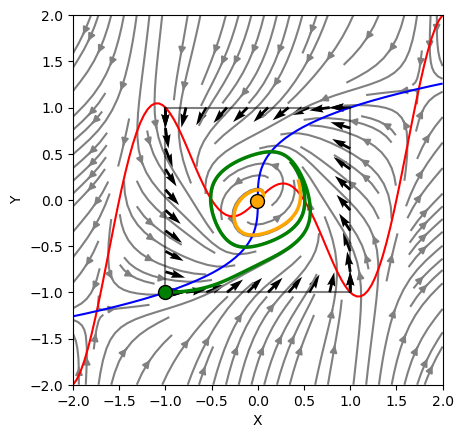

In [32]:

def rhs_2_p139(t, xy, args=None):
    x,y=xy
    dx= -y +x*np.cos(np.pi*x)
    dy= x - y**3    
    return [dx,dy]

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

# Define the range for the plot
rrange=2
xrange = [-rrange, rrange]
yrange = [-rrange, rrange]

# Plot the flow field for the system defined in Exercise 2 on p
ax = plot_flow(ax, rhs_2_p139, xrange=xrange, yrange=yrange, nullclines=True)
plot_vectors_along_line(ax, rhs_2_p139, start_point=[-1,-1], angle=0, length=2, num_vectors=10, color='black')
plot_vectors_along_line(ax, rhs_2_p139, start_point=[-1,-1], angle=np.pi/2, length=2, num_vectors=10, color='black')
plot_vectors_along_line(ax, rhs_2_p139, start_point=[-1,1], angle=0, length=2, num_vectors=10, color='black')
plot_vectors_along_line(ax, rhs_2_p139, start_point=[1,-1], angle=np.pi/2, length=2, num_vectors=10, color='black')
plot_solution(ax, rhs_2_p139, y0=[-1,-1], t_end=10, color='green', init_pt=True, linewidth=2.5)
plot_solution(ax, rhs_2_p139, y0=[-0.01,-0.01], t_end=10, color='orange', init_pt=True, linewidth=2.5)


plt.show()